# Predicting Hospital Readmission for Diabetic Patients

##  Problem Statement

Hospital readmission occurs when a patient, after being discharged, is admitted again within a specific period. High readmission rates negatively impact hospital quality scores and increase healthcare costs. The **Centers for Medicare & Medicaid Services (CMS)** introduced the **Hospital Readmissions Reduction Program (HRRP)** to penalize hospitals with excessive readmissions.

Although diabetes is not currently included in HRRP penalties, it remains a costly chronic disease, with **over $41 billion spent in 2011** on readmissions within 30 days of discharge. Accurately predicting which diabetic patients are at higher risk of early readmission can help hospitals **reduce costs, allocate resources efficiently, and improve patient care**.

##  Objective

This study aims to develop a predictive model that determines the **likelihood of diabetic patients being readmitted within 30 days** of discharge. By analyzing patient demographics, clinical procedures, and hospital attributes, we seek to:

- **Identify key factors** influencing hospital readmissions for diabetic patients.
- **Develop machine learning models** to predict readmission risk.
- **Provide insights** to hospitals for optimizing diabetes management and reducing costs.




### Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


from sklearn.linear_model import LogisticRegression

# TensorFlow and Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC

from sklearn.utils.class_weight import compute_class_weight

# Scikit-learn metrics for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# For visualization
import matplotlib.pyplot as plt

# For numerical operations
import numpy as np

### Creating functions

In [2]:
# Creating a function that converts the ICD-9 codes into broad disease categories

def categorize_icd9(code):
    """ Convert ICD-9 codes into broad disease categories """
    if pd.isna(code):
        return "Unknown"
    code = str(code)
    
    if code.startswith('V'):
        return "V-Code (Health Services)"
    if code.startswith('E'):
        return "E-Code (External Injury)"

    try:
        code = int(float(code))
        if 1 <= code <= 139:
            return "Infectious Disease"
        elif 140 <= code <= 239:
            return "Neoplasms"
        elif 240 <= code <= 279:
            return "Endocrine (e.g., Diabetes)"
        elif 280 <= code <= 289:
            return "Blood Diseases"
        elif 290 <= code <= 319:
            return "Mental Disorders"
        elif 320 <= code <= 389:
            return "Nervous System"
        elif 390 <= code <= 459:
            return "Circulatory System"
        elif 460 <= code <= 519:
            return "Respiratory System"
        elif 520 <= code <= 579:
            return "Digestive System"
        elif 580 <= code <= 629:
            return "Genitourinary System"
        elif 630 <= code <= 679:
            return "Pregnancy-related"
        elif 680 <= code <= 709:
            return "Skin Diseases"
        elif 710 <= code <= 739:
            return "Musculoskeletal"
        elif 740 <= code <= 759:
            return "Congenital Disorders"
        elif 760 <= code <= 779:
            return "Perinatal Conditions"
        elif 780 <= code <= 799:
            return "Symptoms & Ill-defined"
        elif 800 <= code <= 999:
            return "Injury & Poisoning"
    except ValueError:
        return "Unknown"
    
    return "Other"


In [3]:
from sklearn.model_selection import GroupShuffleSplit

def split_by_patient(df, test_size=0.2, random_state=42):
    """
    Split the dataset ensuring all encounters for a patient stay together.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame containing patient data
    test_size : float, default=0.2
        The proportion of patients to include in the test split
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    train_df : pandas DataFrame
        Training set with (1-test_size) of patients
    test_df : pandas DataFrame
        Test set with test_size of patients
    """
    
    # Initialize the GroupShuffleSplit
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    # Split based on patient_nbr
    train_idx, test_idx = next(splitter.split(df, groups=df['patient_nbr']))
    
    # Create the train and test sets
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    # Print split information
    print(f"Total number of encounters: {len(df)}")
    print(f"Number of unique patients: {df['patient_nbr'].nunique()}")
    print("\nTrain set:")
    print(f"Number of encounters: {len(train_df)}")
    print(f"Number of unique patients: {train_df['patient_nbr'].nunique()}")
    print("\nTest set:")
    print(f"Number of encounters: {len(test_df)}")
    print(f"Number of unique patients: {test_df['patient_nbr'].nunique()}")
    
    # Verify no patient overlap
    train_patients = set(train_df['patient_nbr'].unique())
    test_patients = set(test_df['patient_nbr'].unique())
    overlap = train_patients.intersection(test_patients)
    if len(overlap) > 0:
        print("\nWARNING: There are patients in both train and test sets!")
    else:
        print("\nVerified: No patients appear in both train and test sets")
        
    return train_df, test_df

# Usage example:
# train_data, test_data = split_by_patient(your_dataframe)

In [4]:
import pandas as pd
import numpy as np

def encode_categories(df, columns_to_encode, target_col='readmitted_binary', min_samples=10):
    """
    Encode all categorical variables using simple target mean encoding.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Data containing columns to encode
    columns_to_encode : list
        List of all columns to encode
    target_col : str
        Name of the binary target column (default: 'readmitted_binary')
    min_samples : int
        Minimum samples for smoothing (default: 10)
        
    Returns:
    --------
    df_encoded : pandas DataFrame
        DataFrame with encoded columns
    """
    # Copy input data
    df_encoded = df.copy()
    
    # Input validation
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in data")
    
    # Calculate global mean for smoothing
    global_mean = df[target_col].mean()
    
    # Process each column
    for col in columns_to_encode:
        # Calculate category statistics
        category_stats = df.groupby(col)[target_col].agg(['mean', 'count'])
        
        # Apply smoothing based on sample size
        weight = category_stats['count'] / (category_stats['count'] + min_samples)
        smoothed_means = weight * category_stats['mean'] + (1 - weight) * global_mean
        
        # Map encoded values
        df_encoded[f"{col}_encoded"] = df_encoded[col].map(smoothed_means)
        
        # Remove original column
        df_encoded = df_encoded.drop(col, axis=1)
    
    return df_encoded


### Importing Data

In [5]:
# importin train_data
data= pd.read_csv('diabetic_data.csv')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
# Cheking what rows need encoding

numerical_columns = list(data.select_dtypes(include=['number']).columns)
categorical_columns = data.select_dtypes(include='object').columns

print("Numerical Columns:")
print("\n".join(f"- {col}" for col in numerical_columns))
print("\nCategorical Columns:")
print("\n".join(f"- {col}" for col in categorical_columns))

Numerical Columns:
- encounter_id
- patient_nbr
- admission_type_id
- discharge_disposition_id
- admission_source_id
- time_in_hospital
- num_lab_procedures
- num_procedures
- num_medications
- number_outpatient
- number_emergency
- number_inpatient
- number_diagnoses

Categorical Columns:
- race
- gender
- age
- weight
- payer_code
- medical_specialty
- diag_1
- diag_2
- diag_3
- max_glu_serum
- A1Cresult
- metformin
- repaglinide
- nateglinide
- chlorpropamide
- glimepiride
- acetohexamide
- glipizide
- glyburide
- tolbutamide
- pioglitazone
- rosiglitazone
- acarbose
- miglitol
- troglitazone
- tolazamide
- examide
- citoglipton
- insulin
- glyburide-metformin
- glipizide-metformin
- glimepiride-pioglitazone
- metformin-rosiglitazone
- metformin-pioglitazone
- change
- diabetesMed
- readmitted


In [8]:
data.sample(5).T

,99029,72875,3828,40851,94477
encounter_id,408451496,214248498,22788300,126721998,348945200
patient_nbr,41110452,70577406,6884595,24539778,141326411
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,AfricanAmerican
gender,Female,Female,Female,Female,Male
age,[70-80),[30-40),[10-20),[30-40),[30-40)
weight,?,?,?,?,?
admission_type_id,3,2,1,3,3
discharge_disposition_id,1,1,1,1,1
admission_source_id,1,4,7,1,1
time_in_hospital,8,2,3,3,8


### Splitting dataset so no patient is in both train and test sets

In [9]:
train_data, test_data = split_by_patient(data)

Total number of encounters: 101766
Number of unique patients: 71518

Train set:
Number of encounters: 81613
Number of unique patients: 57214

Test set:
Number of encounters: 20153
Number of unique patients: 14304

Verified: No patients appear in both train and test sets


### Checking missing values

In [10]:
# Count occurrences of 'Unknown/Invalid' in gender
print('gender', train_data['gender'][train_data['gender'] == 'Unknown/Invalid'].count())

# Ensure we are working on a separate copy
train_data = train_data.copy()

# Replace missing values ('?') with NaN
train_data.replace('?', np.nan, inplace=True)

# Remove rows where gender is 'Unknown/Invalid'
train_data = train_data.loc[train_data['gender'] != 'Unknown/Invalid']

gender 1


In [11]:
# Checking and summarizing missing values
missing_data = train_data.isnull().sum().loc[lambda x: x > 0].sort_values(ascending=False)
missing_summary = pd.DataFrame({
    "Missing Count": missing_data,
    "Missing Percentage (%)": (missing_data / len(train_data) * 100).round(2)
})

# Display styled missing values summary
display(
    missing_summary.style
    .format({"Missing Percentage (%)": "{:.2f}%"})
    .set_caption("**Missing Values Summary**")
    .set_properties(**{"text-align": "center"})
)

,Missing Count,Missing Percentage (%)
weight,79008,96.81%
max_glu_serum,77259,94.67%
A1Cresult,67937,83.24%
medical_specialty,39835,48.81%
payer_code,32314,39.59%
race,1863,2.28%
diag_3,1138,1.39%
diag_2,294,0.36%
diag_1,14,0.02%


#### Handling Missing Values
we identified missing values in several columns, including `max_glu_serum` (94.7% missing), `A1Cresult` (83.3% missing), and others such as `weight`, `medical_specialty`, and `payer_code`. 
#### Decision on Missing Data

- **Dropped Columns:**  
  We removed `weight`, `medical_specialty`, and `payer_code` because they contain excessive missing values (≥ 39%), making them unreliable for analysis.

- **Retained Columns:**  
  We kept `max_glu_serum` and `A1Cresult`, despite their high missing rates, as they provide **meaningful information** rather than random gaps.  
  - In this case, `"None"` is not a true missing value (`NaN`), but an indicator that the test was **not performed** for a given patient.

- **Row Removal:**  
  Columns like `diag_1`, `diag_2`, `diag_3`, and `race` had **insignificant missing values** (≤ 2.2%). Therefore, we removed the rows containing missing values in these columns.


In [12]:
# drop columns with more than 39% missing values
train_data= train_data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

# drop rows with missing values
train_data= train_data.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'])

# Fill NaN values with 0 using explicit assignment to avoid FutureWarning
train_data = train_data.copy()
train_data['max_glu_serum'] = train_data['max_glu_serum'].fillna(0)
train_data['A1Cresult'] = train_data['A1Cresult'].fillna(0)

In [13]:
# Checking if all missing values where delt with
missing_values = train_data.isnull().sum()

if missing_values.any():
        print(missing_values[missing_values>0])
else:
    print('-'*20)
    print('No missing values')
    print('-'*20)

--------------------
No missing values
--------------------


## Analyze Data

Target Variable, **`readmitted`**, includes three possible values:  
- **>30** (Patient readmitted after more than 30 days)  
- **<30** (Patient readmitted within 30 days)  
- **NO** (Patient was not readmitted)   

Since our primary focus is determining **whether a patient was readmitted or not**, rather than the specific time frame of readmission, we consolidate the categories as follows:  

- **Positive Outcome (Readmitted):** Both **>30** and **<30** are mapped to `1`.  
- **Negative Outcome (Not Readmitted):** **NO** is mapped to `0`.  



In [14]:
# Convert the target variable to binary

train_data['readmitted_binary'] = train_data['readmitted'].map({'NO': 0, '>30': 1, '<30': 1})

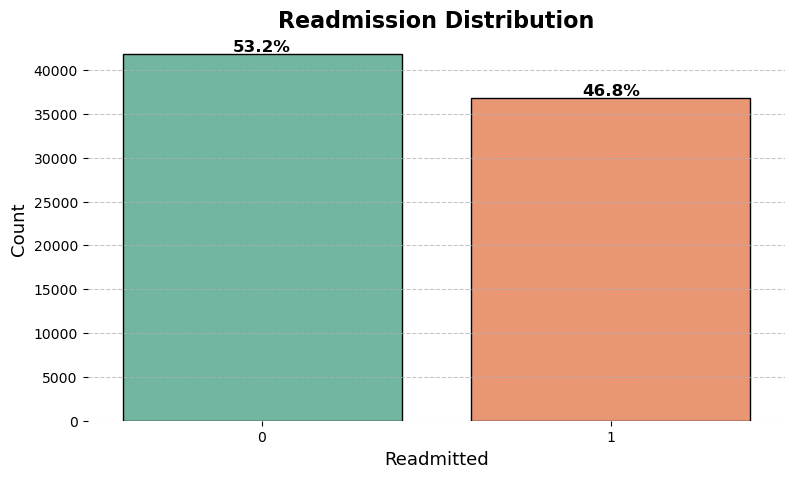

In [15]:
# Plot count distribution
plt.figure(figsize=(9, 5))
ax = sns.countplot(x='readmitted_binary', hue='readmitted_binary', data=train_data, 
                   palette='Set2', edgecolor='black', legend=False)

# Annotate bars with percentage labels
total = len(train_data)
for p in ax.patches:
    ax.annotate(f"{p.get_height() / total:.1%}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
plt.title('Readmission Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Readmitted', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

plt.show()

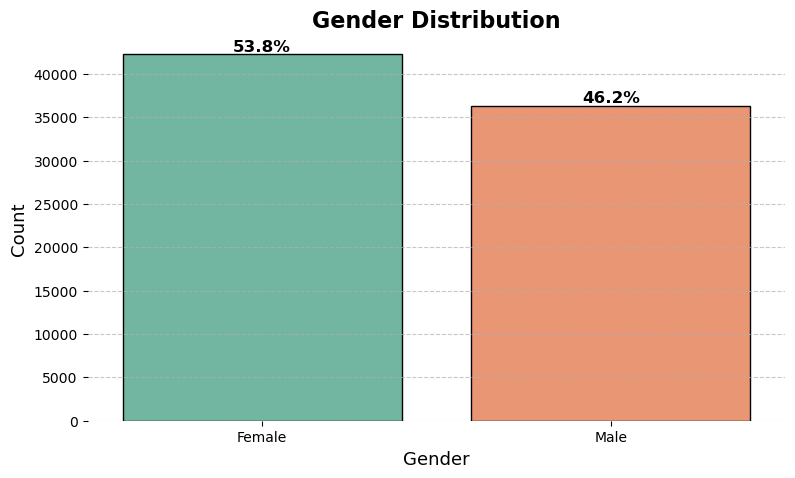

In [16]:
# Plot gender distribution
plt.figure(figsize=(9, 5))
ax = sns.countplot(x='gender', hue='gender', data=train_data, palette='Set2', edgecolor='black', legend=False)

# Annotate bars with percentages
total = len(train_data)
for p in ax.patches:
    ax.annotate(f"{p.get_height() / total:.1%}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
plt.title('Gender Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

plt.show()


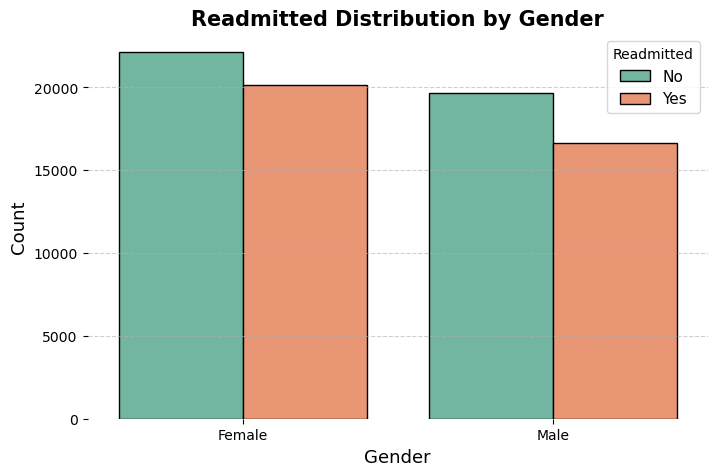

In [17]:
# Figure setup
plt.figure(figsize=(8, 5))

# Count plot with better color and auto-handled categorical labels
ax = sns.countplot(
    x='gender', hue='readmitted_binary', data=train_data, palette='Set2', edgecolor='black'
)

# Labels & Title
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Readmitted Distribution by Gender', fontsize=15, fontweight='bold')

# Improved legend with proper labels
plt.legend(title="Readmitted", labels=["No", "Yes"], fontsize=11)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, bottom=True)

plt.show()


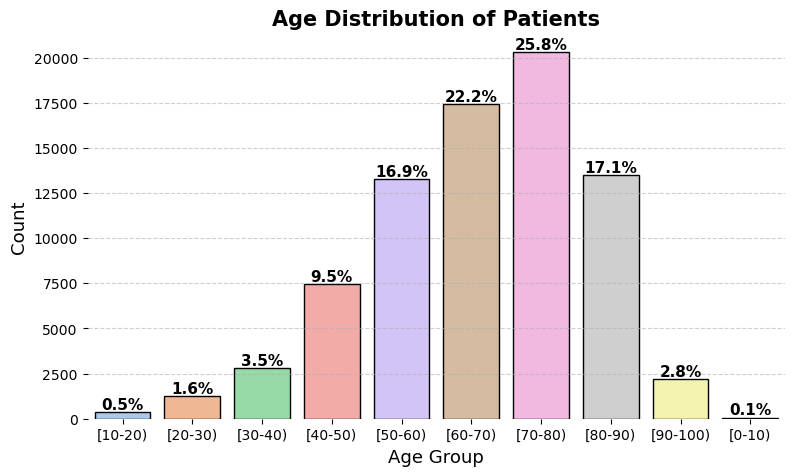

In [18]:
# Plot age distribution
plt.figure(figsize=(9, 5))
ax = sns.countplot(x="age",hue='age', data=train_data, palette="pastel", edgecolor="black")

# Add percentage labels
total = len(train_data)
for p in ax.patches:
    ax.annotate(f"{p.get_height() / total:.1%}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Formatting
plt.xlabel('Age Group', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Age Distribution of Patients', fontsize=15, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, bottom=True)

plt.show()

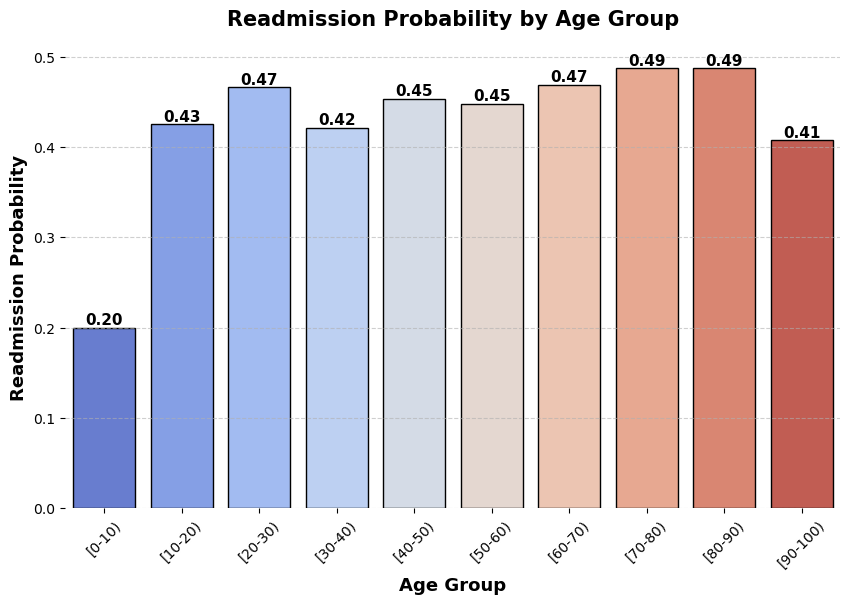

In [19]:
# Compute readmission probability per age group
age_readmit_rates = train_data.groupby('age')['readmitted_binary'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="age", y="readmitted_binary", hue="age", data=age_readmit_rates, 
                 palette="coolwarm", edgecolor="black", legend=False)

# Add train_data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Formatting
plt.xlabel("Age Group", fontsize=13, fontweight='bold')
plt.ylabel("Readmission Probability", fontsize=13, fontweight='bold')
plt.title("Readmission Probability by Age Group", fontsize=15, fontweight='bold', pad=15)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, bottom=True)

plt.show()

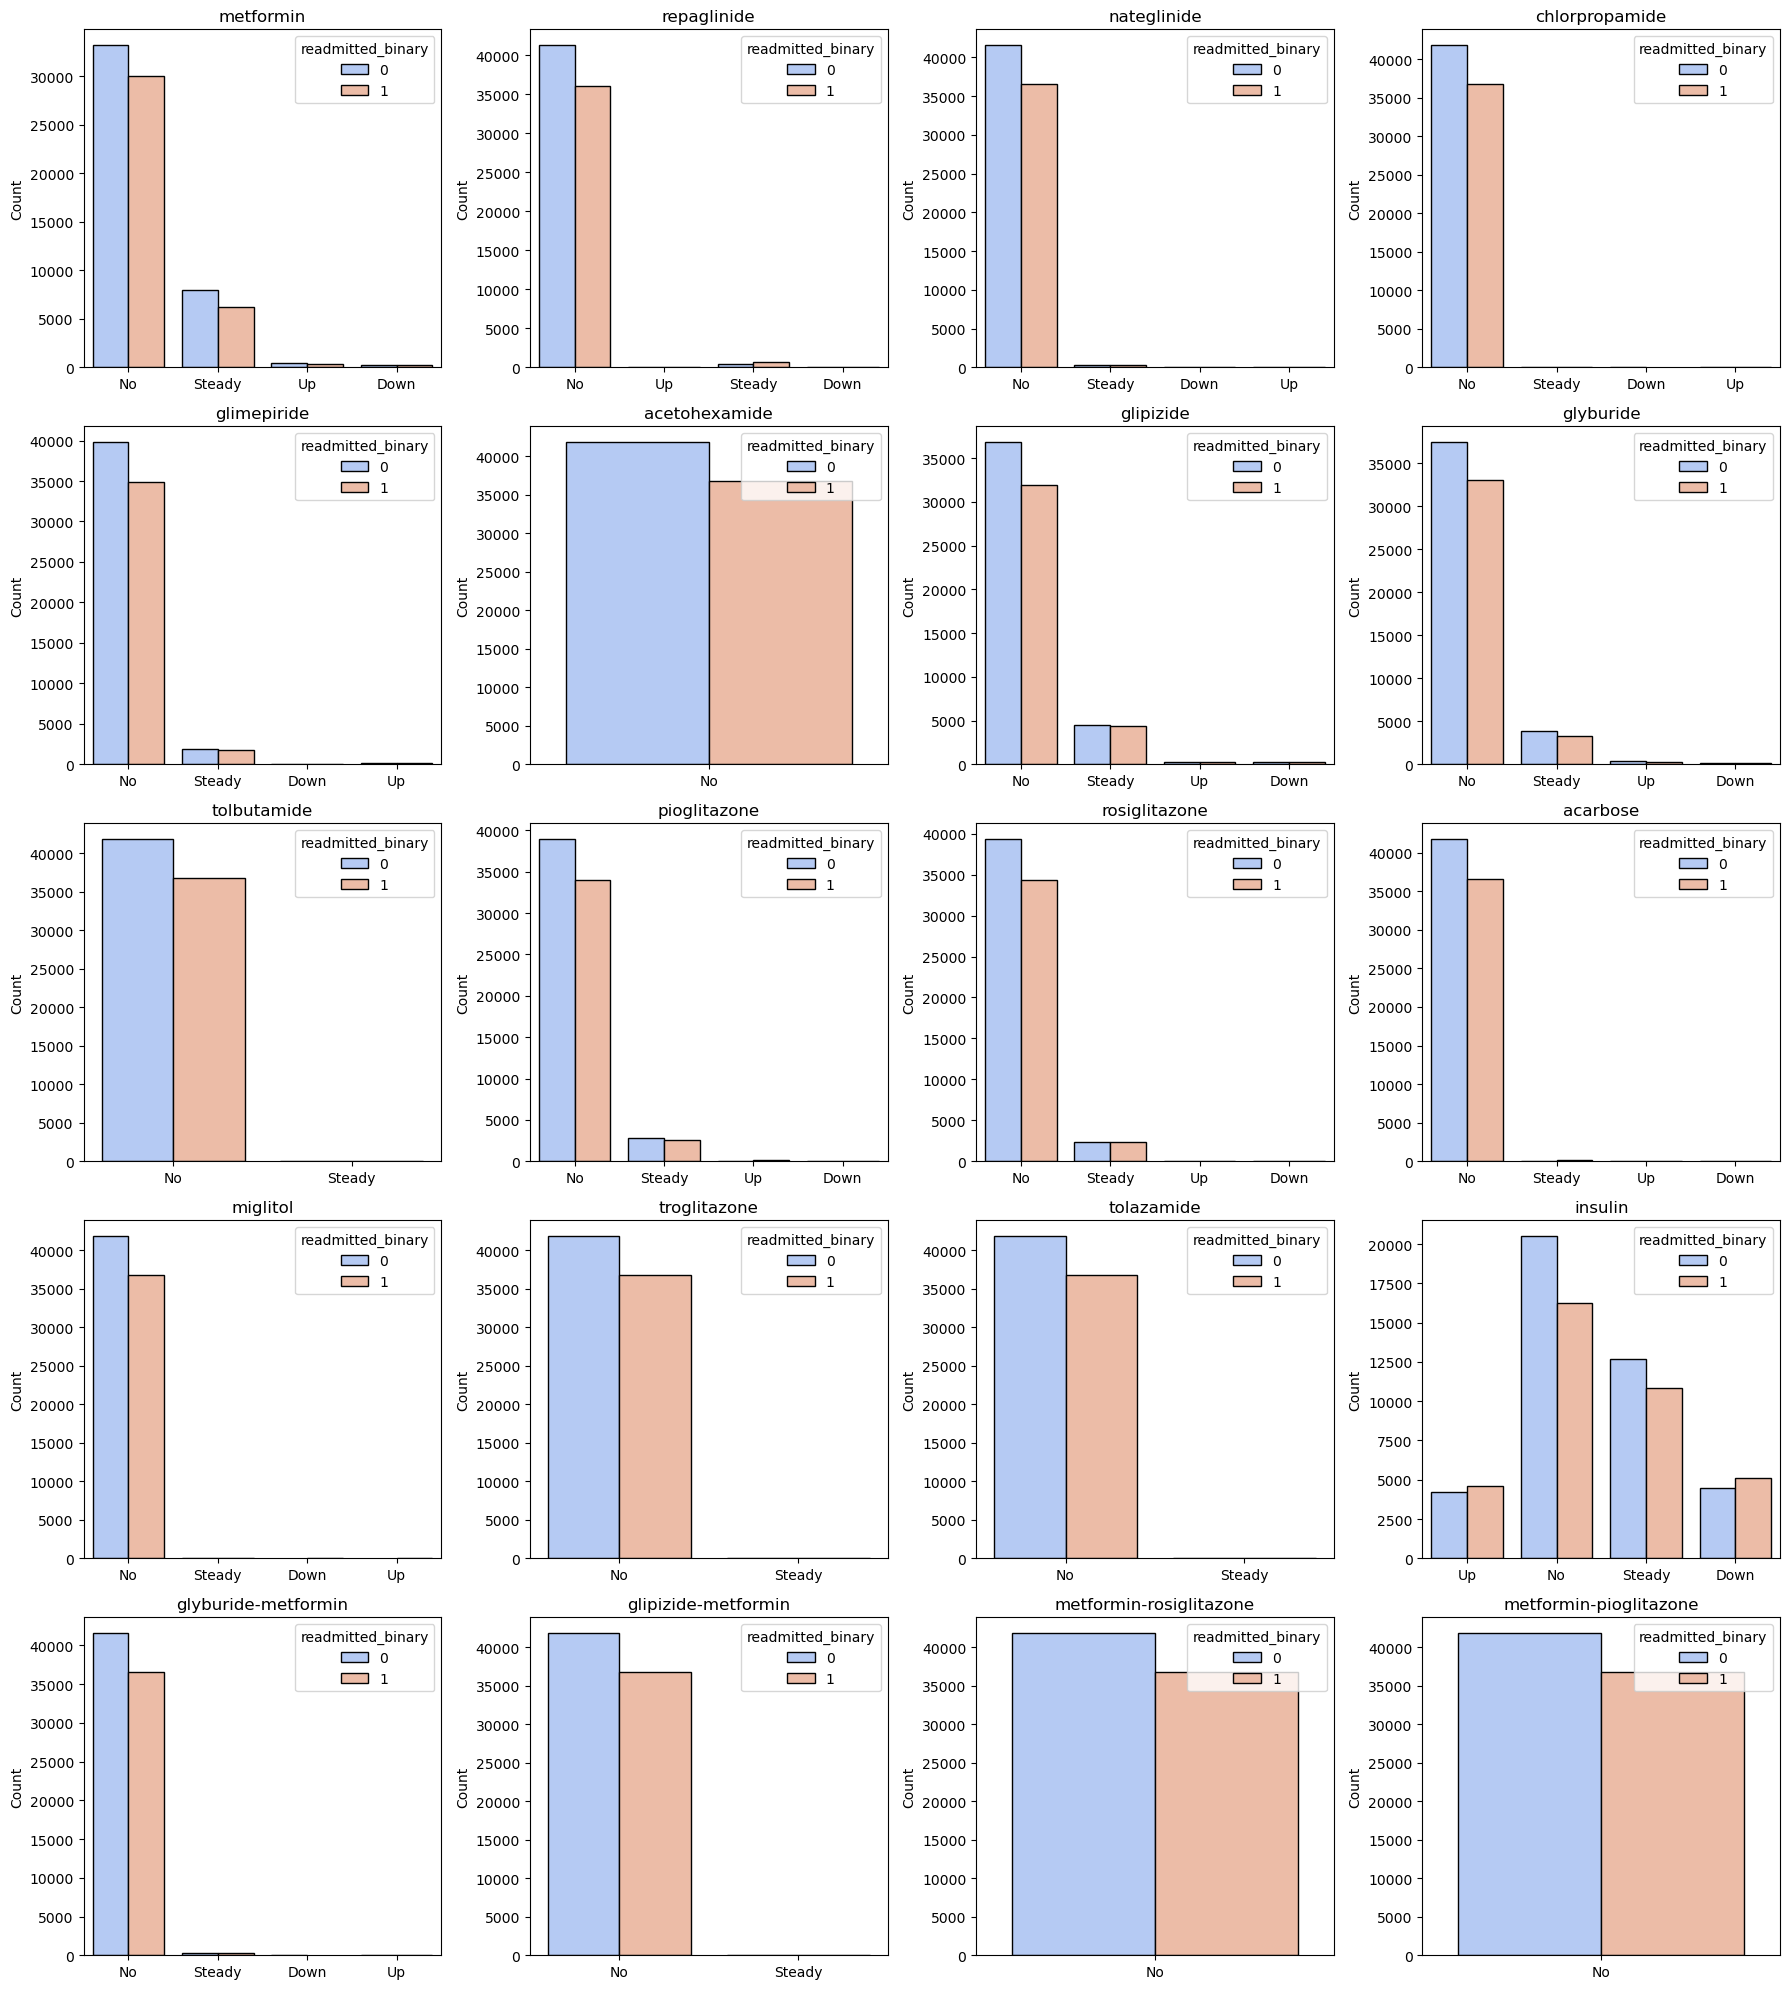

In [20]:
# List of drug columns
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
             'metformin-rosiglitazone', 'metformin-pioglitazone']

# Create subplots with multiple drug distributions
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 20))
axes = axes.flatten()

# Loop through each drug and plot on its respective subplot
for idx, drug in enumerate(drug_cols):
    sns.countplot(x=drug, hue="readmitted_binary", data=train_data, palette="coolwarm", edgecolor="black", ax=axes[idx])
    axes[idx].set_title(drug, fontsize=12)
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

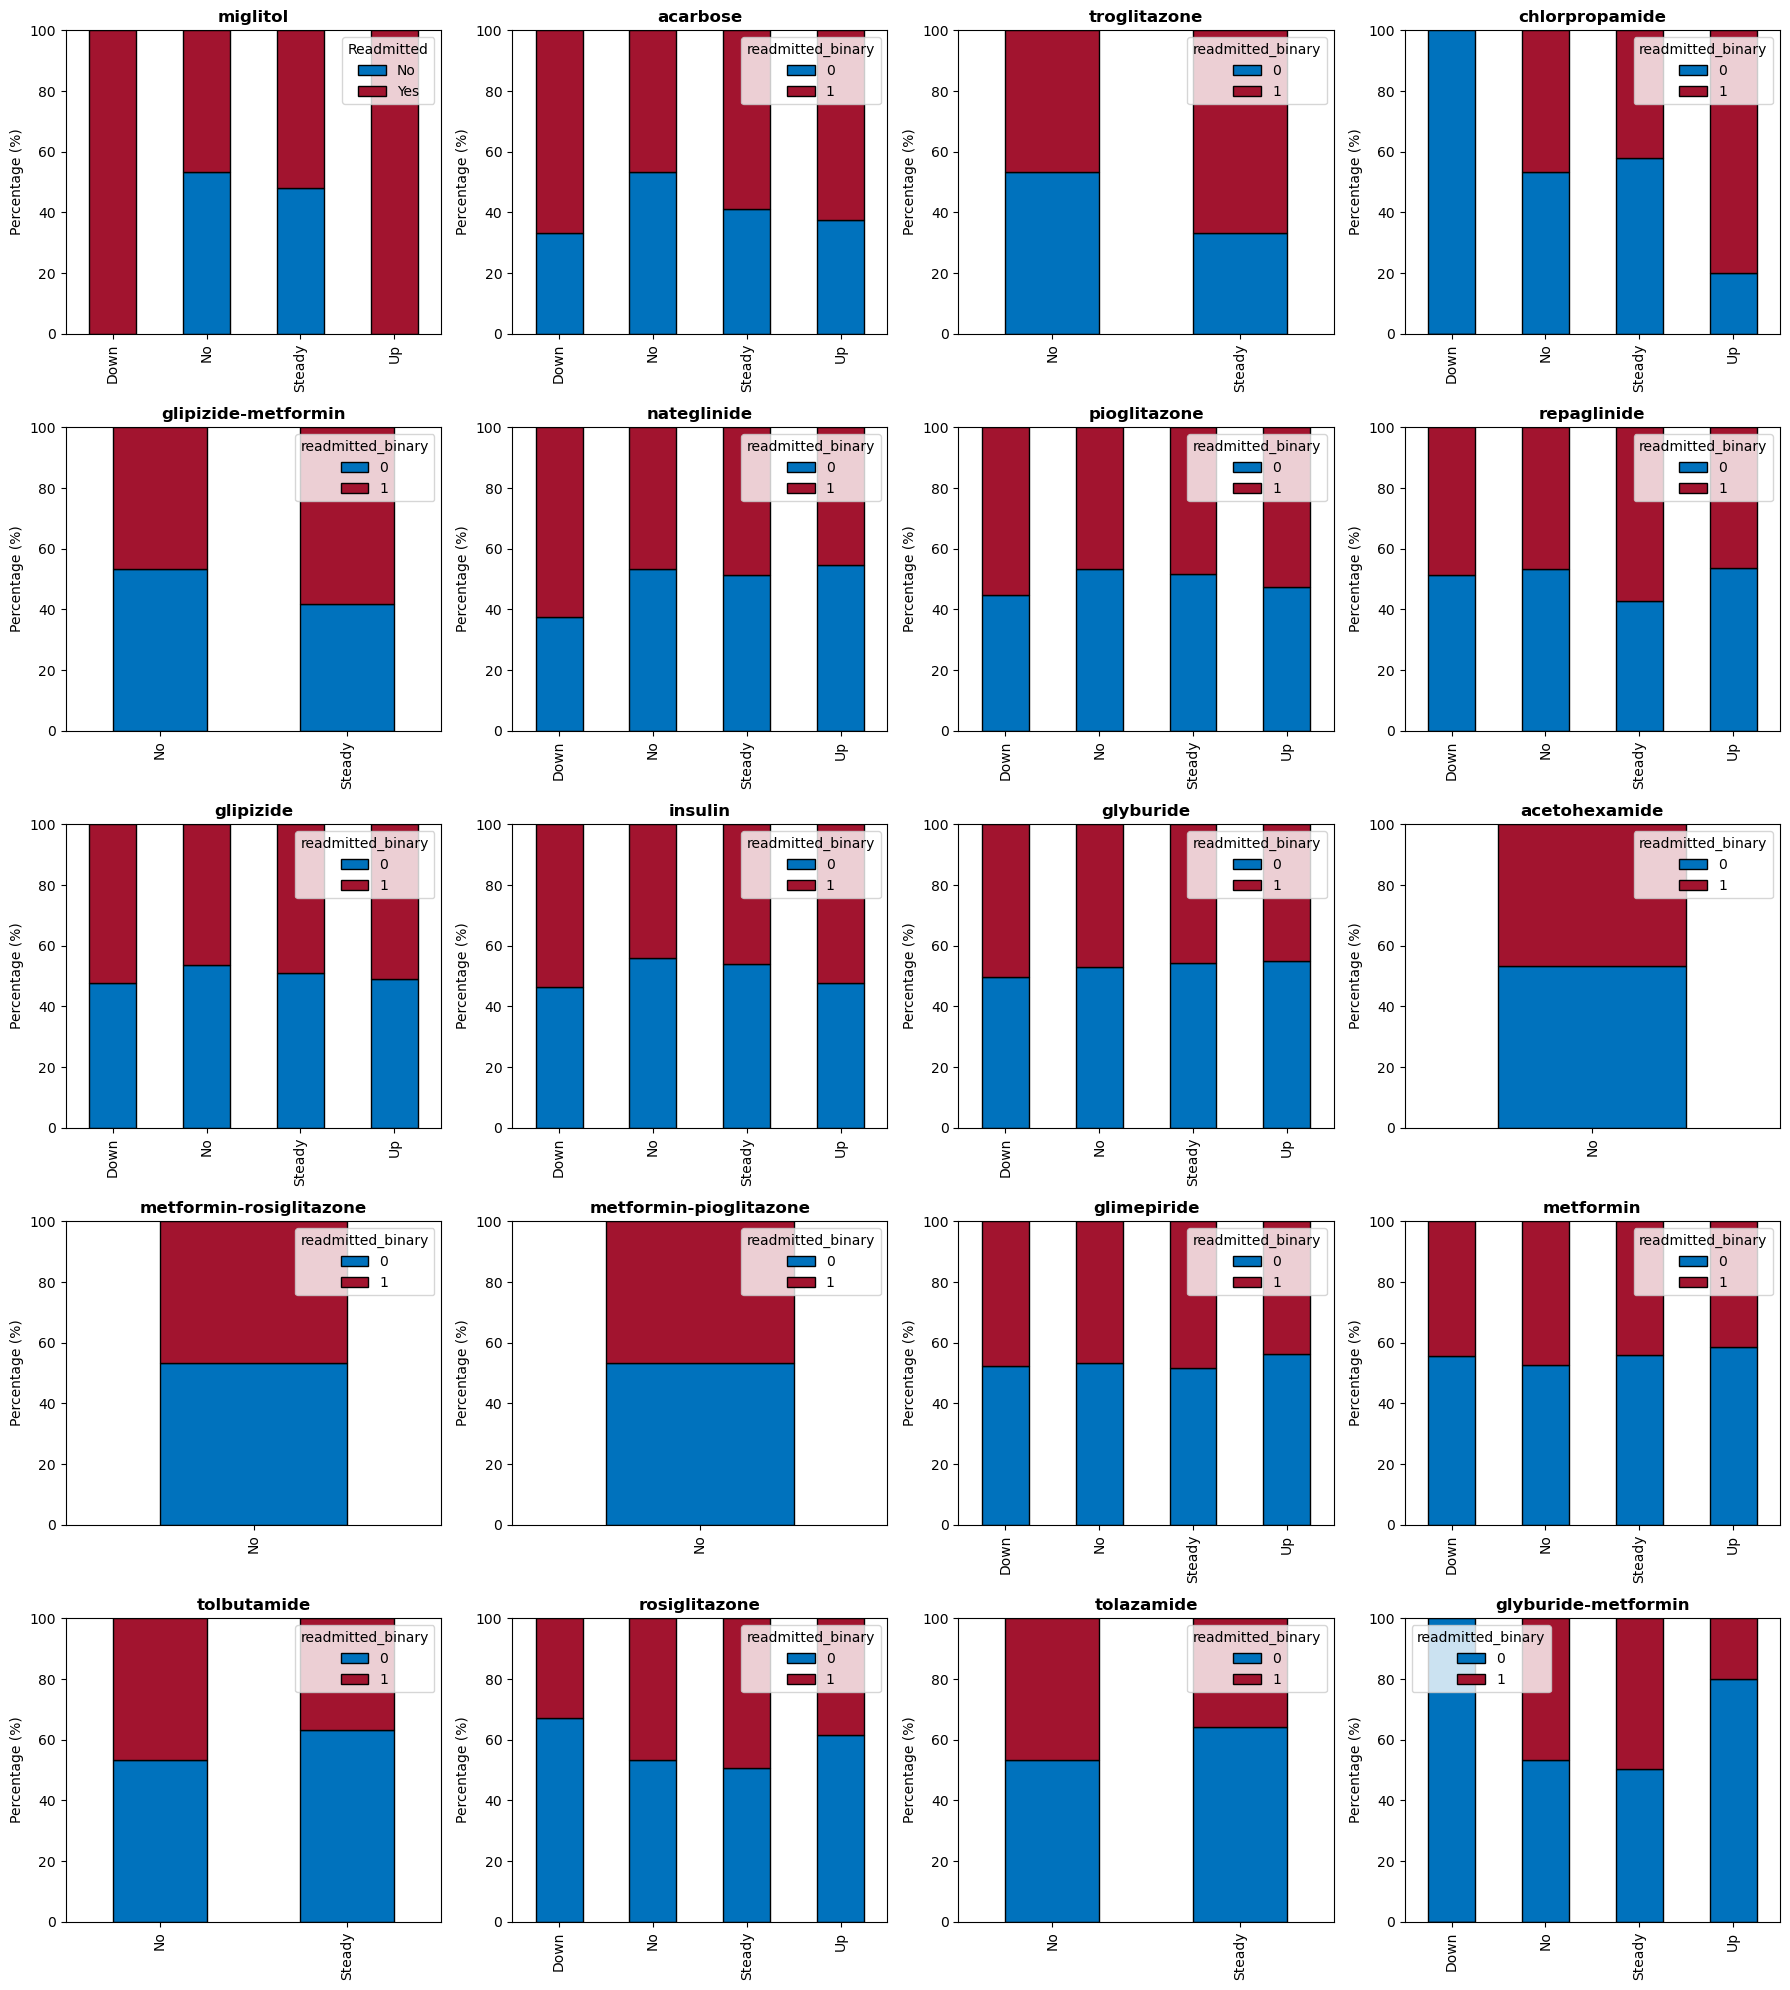

In [21]:
# Compute readmission percentage for each drug
drug_readmit_rates = {}
for drug in drug_cols:
    drug_counts = train_data.groupby([drug, 'readmitted_binary']).size().unstack()
    drug_percent = drug_counts.div(drug_counts.sum(axis=1), axis=0) * 100
    avg_readmit_rate = drug_percent[1].mean()  # Avg. percentage of readmitted
    drug_readmit_rates[drug] = avg_readmit_rate

# Sort drugs by highest readmission percentage
sorted_drugs = sorted(drug_readmit_rates, key=drug_readmit_rates.get, reverse=True)

# Create subplots with sorted drug distributions
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 20))  
axes = axes.flatten()  

# Loop through sorted drugs and plot on subplots
for idx, drug in enumerate(sorted_drugs):
    drug_counts = train_data.groupby([drug, 'readmitted_binary']).size().unstack()
    drug_percent = drug_counts.div(drug_counts.sum(axis=1), axis=0) * 100  
    
    # Plot as stacked bar chart
    drug_percent.plot(kind='bar', stacked=True, ax=axes[idx], color=["#0072BD", "#A2142F"], edgecolor="black")

    # Formatting
    axes[idx].set_title(drug, fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].set_ylim(0, 100)

    # Move legend outside to avoid overlap
    if idx == 0:
        axes[idx].legend(title="Readmitted", labels=["No", "Yes"], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

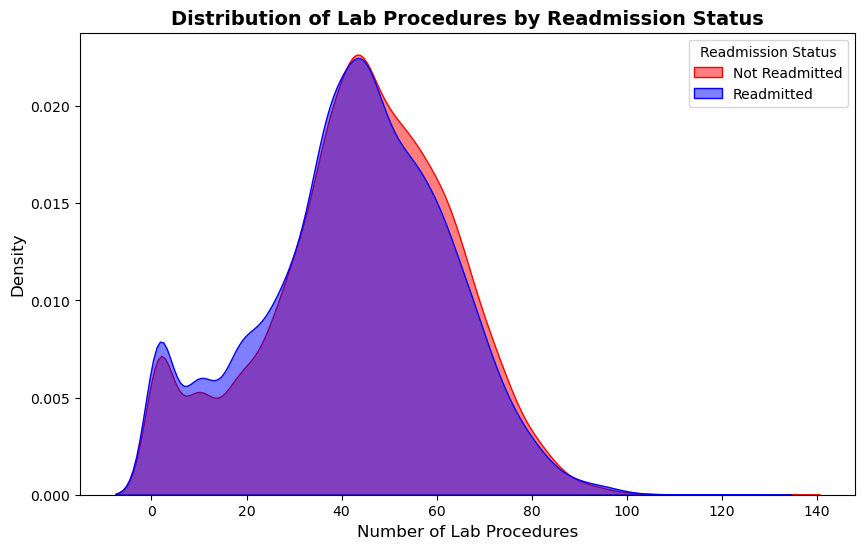

In [22]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted
sns.kdeplot(data=train_data, x="num_lab_procedures", hue="readmitted_binary",
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2)

# Labels & Title
plt.xlabel("Number of Lab Procedures", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Lab Procedures by Readmission Status", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

# Show plot
plt.show()


In [23]:
n_admissions = train_data['encounter_id'].nunique()
n_patients = train_data['patient_nbr'].nunique()

admissions_per_patient = train_data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

print(f"Proportion of patients that have multiple admissions: {multiple_admissions['patient_nbr'].nunique()/n_patients:.2%}")
print(f"Maximum number of admissions for a given patient: {multiple_admissions['count'].max()}")

Proportion of patients that have multiple admissions: 23.81%
Maximum number of admissions for a given patient: 39


In [24]:
# Unique admissions & patients
n_admissions = train_data['encounter_id'].nunique()
n_patients = train_data['patient_nbr'].nunique()

# Count admissions per patient
admissions_per_patient = train_data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']

# Identify patients with multiple admissions
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

# Compute additional insights
multiple_admission_rate = multiple_admissions['patient_nbr'].nunique() / n_patients
max_admissions = multiple_admissions['count'].max()


# Display key statistics
print("="*50)
print(f"Total Admissions: {n_admissions:,}")
print(f"Total Unique Patients: {n_patients:,}")
print(f"Proportion of Patients with Multiple Admissions: {multiple_admission_rate:.2%}")
print(f"Maximum Number of Admissions for a Single Patient: {max_admissions}")
print("="*50)


Total Admissions: 78,592
Total Unique Patients: 54,882
Proportion of Patients with Multiple Admissions: 23.81%
Maximum Number of Admissions for a Single Patient: 39


## Feature Engeniering

### Remapping Categorical values

In [25]:
# Calculate Total Medication Changes
train_data['total_medication_changes'] = train_data[drug_cols].apply(lambda row: sum(row.isin(['Up', 'Down'])), axis=1)

# Define a threshold for polypharmacy (e.g., more than 10 medications)
POLYPHARMACY_THRESHOLD = 10

# Create Polypharmacy Indicator
train_data['polypharmacy_indicator'] = (train_data['num_medications'] > POLYPHARMACY_THRESHOLD).astype(int)

# Calculate Insulin Dependence Ratio
train_data['insulin_used'] = train_data['insulin'].apply(lambda x: 0 if x == 'No' else 1)
train_data['insulin_dependence_ratio'] = train_data['insulin_used'] / (train_data['num_medications'] + 1)  # +1 to avoid division by zero


# Compute Stability Index (higher values mean more instability)
train_data['stability_index'] = (train_data['num_medications'] + train_data['num_lab_procedures']) / (train_data['time_in_hospital'] + 1)  # Avoid division by zero


In [26]:
#categorize ICD-9 codes into disease categories
train_data['diag_1_category'] = train_data['diag_1'].apply(categorize_icd9)
train_data['diag_2_category'] = train_data['diag_2'].apply(categorize_icd9)
train_data['diag_3_category'] = train_data['diag_3'].apply(categorize_icd9)

# Drop original ICD-9 columns
train_data = train_data.drop(columns=['diag_1', 'diag_2', 'diag_3', 'readmitted'])

In [27]:
# Define categorical columns
columns_to_encode = [
    'gender', 'race', 'change', 'diabetesMed', 'age', 'max_glu_serum', 'A1Cresult',
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 
    'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone', 
    'metformin-pioglitazone', 'examide', 'citoglipton', 'glimepiride-pioglitazone', 
    'diag_1_category', 'diag_2_category', 'diag_3_category'
]

# Encode categorical features in training data
train_data = encode_categories(
    df=train_data,
    columns_to_encode=columns_to_encode,
    target_col='readmitted_binary'
)


### Creating new features

In [28]:
# creating a number of visits column

train_data['num_visits'] = train_data['number_outpatient'] + train_data['number_emergency'] + train_data['number_inpatient']

In [29]:
# Ensure required columns exist in DataFrame before proceeding
existing_columns = set(train_data.columns)

# Define interaction terms (Only keep valid ones)
datainteractionterms = [
    ('num_medications', 'time_in_hospital'),
    ('num_medications', 'num_procedures'),
    ('time_in_hospital', 'num_lab_procedures'),
    ('num_medications', 'num_lab_procedures'),
    ('num_medications', 'number_diagnoses'),
    ('change', 'num_medications'),
    ('number_diagnoses', 'time_in_hospital'),
    ('num_medications', 'num_visits')  
]

# Filter interaction terms to keep only existing columns
valid_interaction_terms = [(col1, col2) for col1, col2 in datainteractionterms if col1 in existing_columns and col2 in existing_columns]
# Ensure all relevant columns are numeric
for col1, col2 in valid_interaction_terms:
    train_data[col1] = pd.to_numeric(train_data[col1], errors='coerce')
    train_data[col2] = pd.to_numeric(train_data[col2], errors='coerce')

# Generate interaction terms
for col1, col2 in valid_interaction_terms:
    name = col1 + '|' + col2
    
    # Multiplication
    new_col_mult = name + '_mult'
    train_data[new_col_mult] = train_data[col1] * train_data[col2]
    numerical_columns.append(new_col_mult)

    # Addition
    new_col_sum = name + '_sum'
    train_data[new_col_sum] = train_data[col1] + train_data[col2]
    numerical_columns.append(new_col_sum)

    # Division (Avoiding division by zero)
    new_col_ratio = name + '_ratio'
    train_data[new_col_ratio] = train_data[col1] / (train_data[col2] + 1e-5)
    numerical_columns.append(new_col_ratio)

# Remove duplicate column names in numerical_columns
numerical_columns = list(set(numerical_columns))

# Generate Polynomial Features
train_data['num_medications_squared'] = train_data['num_medications'] ** 2
train_data['time_in_hospital_squared'] = train_data['time_in_hospital'] ** 2
train_data['number_diagnoses_squared'] = train_data['number_diagnoses'] ** 2

# Add polynomial features to numerical_columns
numerical_columns.extend(['num_medications_squared', 'time_in_hospital_squared', 'number_diagnoses_squared'])

# Generate Healthcare Utilization Ratios
train_data['num_medications_time_in_hospital_ratio'] = train_data['num_medications'] / (train_data['time_in_hospital'] + 1e-5)
train_data['num_medications_num_lab_procedures_ratio'] = train_data['num_medications'] / (train_data['num_lab_procedures'] + 1e-5)
train_data['number_diagnoses_time_in_hospital_ratio'] = train_data['number_diagnoses'] / (train_data['time_in_hospital'] + 1e-5)

# Add ratio features to numerical_columns
numerical_columns.extend(['num_medications_time_in_hospital_ratio', 'num_medications_num_lab_procedures_ratio', 'number_diagnoses_time_in_hospital_ratio'])

# Ensure numerical_columns does not have duplicates
numerical_columns = list(set(numerical_columns))




### Checking if new features are statistically significant

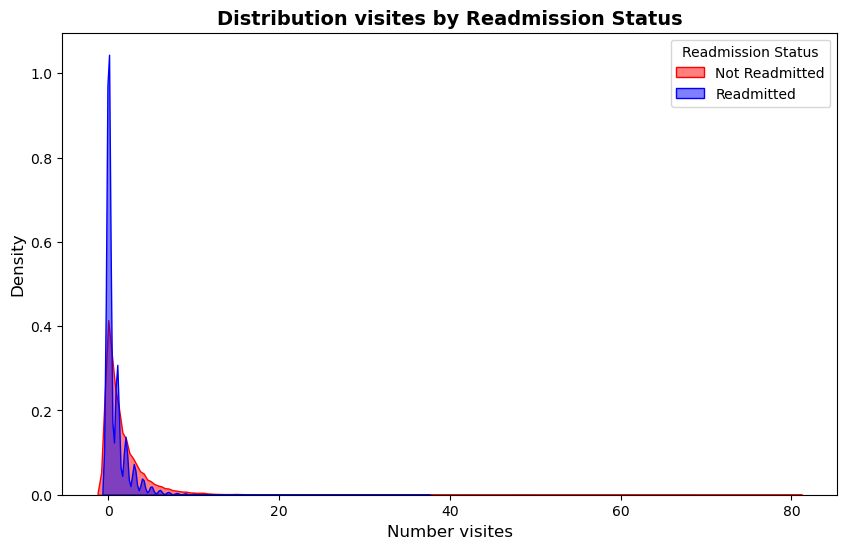

In [30]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted
sns.kdeplot(data=train_data, x="num_visits", hue="readmitted_binary",
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2)

# Labels & Title
plt.xlabel("Number visites", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution visites by Readmission Status", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

# Show plot
plt.show()


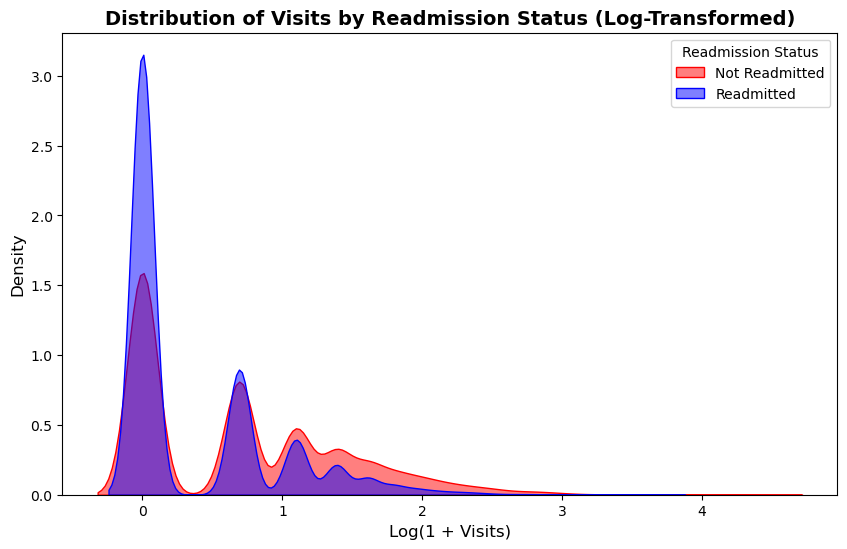

In [31]:
# Set figure size
plt.figure(figsize=(10, 6))

# KDE plot for Not Readmitted & Readmitted, applying log transformation on-the-fly
sns.kdeplot(data=train_data, 
            x=np.log1p(train_data['num_visits']), 
            hue=train_data['readmitted_binary'],
            palette={0: "blue", 1: "red"}, fill=True, alpha=0.5, 
            common_norm=False, bw_adjust=1.2) 

# Labels & Title
plt.xlabel("Log(1 + Visits)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Visits by Readmission Status (Log-Transformed)", fontsize=14, fontweight="bold")

# Adjust legend placement
plt.legend(title="Readmission Status", labels=["Not Readmitted", "Readmitted"], loc="upper right")

plt.show()


In [32]:
from scipy.stats import mannwhitneyu

# Apply log transformation dynamically
readmitted_visits = np.log1p(train_data[train_data['readmitted_binary'] == 1]['num_visits'])
not_readmitted_visits = np.log1p(train_data[train_data['readmitted_binary'] == 0]['num_visits'])

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(readmitted_visits, not_readmitted_visits, alternative='greater')

# Print results
print("Mann-Whitney U Test Results:")
print(f"Statistic = {stat:.4f}, P-value = {p_value:.4e}")

if p_value < 0.05:
    print("P-value < 0.05: Reject Null Hypothesis (Significant Difference)")
else:
    print("P-value >= 0.05: Fail to Reject Null Hypothesis (No Significant Difference)")


Mann-Whitney U Test Results:
Statistic = 961397222.5000, P-value = 0.0000e+00
P-value < 0.05: Reject Null Hypothesis (Significant Difference)


since p<0.05 it confirms that the number of visits is significantly different between readmitted and non-readmitted patients.

#### **Log Transformation Analysis**

##### **Objective**
We assess numerical features to determine if log transformation is needed to improve distribution and reduce skewness.

##### **Process**
1. **Check Skewness & Kurtosis**  
   - If both values are high, the feature is likely skewed.

2. **Apply Log Transformation When Necessary**  
   - `log` is used when zero values are minimal.  
   - `log1p` is used when zero values are present.

3. **Evaluate Transformation Impact**  
   - Compare skewness and kurtosis before and after transformation.  
   - Perform a **p-value test** to measure statistical significance.

4. **Decision Making**  
   - If transformation improves distribution (**p-value < 0.05**), it is applied.  
   - Otherwise, the feature remains unchanged.

In [33]:
# Ensure numerical_columns is a list
numerical_columns = train_data.select_dtypes(include='number').columns.tolist()

# Append 'num_visits' column if not already present
if 'num_visits' not in numerical_columns:
    numerical_columns.append('num_visits')

# Initialize list to store results
data_records = []

# Iterate through numerical columns
for col in numerical_columns:
    skew_before = train_data[col].skew()
    kurt_before = train_data[col].kurtosis()
    std_before = train_data[col].std()

    log_needed = 'No'
    log_method = 'NA'
    skew_after = skew_before
    kurt_after = kurt_before
    std_after = std_before
    p_value = np.nan  # Default NaN if no transformation applied

    # Apply log transformation if skewness and kurtosis exceed thresholds
    if abs(skew_before) > 2 and abs(kurt_before) > 2:
        log_needed = 'Yes'

        if (train_data[col] == 0).sum() / len(train_data) <= 0.02:
            log_method = 'log'
            transformed = np.log(train_data[col][train_data[col] > 0])  
        else:
            log_method = 'log1p'
            transformed = np.log1p(train_data[col])  

        # Store new stats after transformation
        skew_after = transformed.skew()
        kurt_after = transformed.kurtosis()
        std_after = transformed.std()

        # Perform Mann-Whitney U test to check distribution shift
        stat, p_val = mannwhitneyu(train_data[col].dropna(), transformed.dropna(), alternative='two-sided')
        p_value = f"{p_val:.2e}"

    # Append results to list
    data_records.append([col, skew_before, kurt_before, std_before, log_needed, 
                         log_method, skew_after, kurt_after, std_after, p_value])

# Create DataFrame from records
statdataframe = pd.DataFrame(data_records, columns=[
    'Feature', 'Skew Before', 'Kurtosis Before', 'Std Dev Before', 
    'Log Transform Needed', 'Log Type', 'Skew After', 'Kurtosis After', 
    'Std Dev After', 'P-Value'
])

# Format P-Value column
statdataframe['P-Value'] = statdataframe['P-Value'].apply(lambda x: f"{x}" if x != np.nan else "NaN")

# Display DataFrame in a better format

display(statdataframe.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4A90E2'), ('color', 'white'), ('text-align', 'center')]},
    {'selector': 'tbody td', 'props': [('text-align', 'center')]}
]).set_properties(**{'font-size': '12px'}))


,Feature,Skew Before,Kurtosis Before,Std Dev Before,Log Transform Needed,Log Type,Skew After,Kurtosis After,Std Dev After,P-Value
0,encounter_id,0.694237,-0.097587,102476421.550248,No,NA,0.694237,-0.097587,102476421.550248,nan
1,patient_nbr,0.454169,-0.351799,38696976.608114,No,NA,0.454169,-0.351799,38696976.608114,nan
2,admission_type_id,1.581458,1.881377,1.455483,No,NA,1.581458,1.881377,1.455483,nan
3,discharge_disposition_id,2.534119,5.835310,5.297376,Yes,log,1.053483,-0.117694,0.978081,0.00e+00
4,admission_source_id,1.026819,1.716934,4.080851,No,NA,1.026819,1.716934,4.080851,nan
5,time_in_hospital,1.127958,0.833316,2.997911,No,NA,1.127958,0.833316,2.997911,nan
6,num_lab_procedures,-0.236181,-0.252764,19.717605,No,NA,-0.236181,-0.252764,19.717605,nan
7,num_procedures,1.306238,0.827200,1.708484,No,NA,1.306238,0.827200,1.708484,nan
8,num_medications,1.347950,3.583853,8.101835,No,NA,1.347950,3.583853,8.101835,nan
9,number_outpatient,8.740900,143.530668,1.285090,Yes,log1p,2.717781,7.711769,0.433147,1.27e-12


In [34]:
# Create a copy of the dataset to apply transformations
log_transformed_data = train_data.copy()

# Iterate through the transformation DataFrame
for index, row in statdataframe.iterrows():
    col = row['Feature']
    
    if row['Log Transform Needed'] == 'Yes':
        if row['Log Type'] == 'log':
            log_transformed_data[col] = np.log(log_transformed_data[col].replace(0, np.nan))  
        elif row['Log Type'] == 'log1p':
            log_transformed_data[col] = np.log1p(log_transformed_data[col])


In [35]:
# Sort train_data by patient ID and encounter date
data_sorted = log_transformed_data.sort_values(by=['patient_nbr', 'encounter_id'])

# Keep only the first encounter for each patient
collapsed_data = data_sorted.drop_duplicates(subset=['patient_nbr'], keep='first')

# Compute the total number of encounters for each patient
encounter_counts = log_transformed_data['patient_nbr'].value_counts().reset_index()
encounter_counts.columns = ['patient_nbr', 'total_encounters']

# Merge total encounters back to the collapsed dataset
collapsed_data = collapsed_data.merge(encounter_counts, on='patient_nbr', how='left')

# Calculate Average Length of Stay per Visit
collapsed_data['avg_los_per_visit'] = collapsed_data['time_in_hospital'] / (collapsed_data['total_encounters'] + 1)

# Display summary
print(f"Original dataset size: {len(log_transformed_data):,}")
print(f"Collapsed dataset size: {len(collapsed_data):,}")
print(f"Patients with multiple encounters (before collapsing): {(encounter_counts['total_encounters'] > 1).sum():,}")

# Display the updated dataset
collapsed_data.head()


Original dataset size: 78,592
Collapsed dataset size: 54,882
Patients with multiple encounters (before collapsing): 13,069


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,num_medications|num_visits_sum,num_medications|num_visits_ratio,num_medications_squared,time_in_hospital_squared,number_diagnoses_squared,num_medications_time_in_hospital_ratio,num_medications_num_lab_procedures_ratio,number_diagnoses_time_in_hospital_ratio,total_encounters,avg_los_per_visit
0,24437208,135,2,0.000000,1,8,77,6,33,0.0,...,33,3.300000e+06,6.993015,4.158883,64,1.417065,-0.847298,0.999999,2,2.666667
1,29758806,378,3,0.000000,1,2,49,1,11,0.0,...,11,1.100000e+06,4.795791,1.386294,9,1.704743,-1.493925,1.499993,1,1.000000
2,189899286,729,1,1.098612,7,4,68,2,23,0.0,...,23,2.300000e+06,6.270988,2.772589,81,1.749197,-1.084014,2.249994,1,2.000000
3,64331490,774,1,0.000000,7,3,46,0,20,0.0,...,20,2.000000e+06,5.991465,2.197225,81,1.897117,-0.832909,2.999990,1,1.500000
4,30180318,1152,1,0.000000,7,6,45,4,15,0.0,...,17,7.499963e+00,5.416100,3.583519,36,0.916289,-1.098613,0.999998,3,1.500000


In [36]:
from preprocessing import get_preprocessing_pipeline

# Get the pipeline
pipeline = get_preprocessing_pipeline()

# changing test dataset with pipeline

test_data = pipeline.fit_transform(test_data)

# Reorder collapse_data columns to match train_df
collapse_data = collapsed_data[test_data.columns]


## Training Model

### Feature Selection with Grid Search

In [37]:
# spliting data to target and features

X_train = collapsed_data.drop(columns=['readmitted_binary'])
y_train = collapsed_data['readmitted_binary']

X_test = test_data.drop(columns=['readmitted_binary'])
y_test = test_data['readmitted_binary']



In [38]:
# Parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [10, 15, 20, 28, 35],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10], 
    'max_features': ['sqrt', 'log2', None]  
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data_train
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Accuracy from Grid Search: {grid_search.best_score_:.4f}")

# Train the best model on full training data_train
best_dtree = grid_search.best_estimator_
best_dtree.fit(X_train, y_train)

# Ensure X_test columns are in the same order as X_train
X_test = X_test[X_train.columns]

# Make predictions
y_pred = best_dtree.predict(X_test)

# Evaluate performance
print("\nOptimized Model Performance:")
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Optimized Precision: {precision_score(y_test, y_pred, average='binary'):.4f}")
print(f"Optimized Recall: {recall_score(y_test, y_pred, average='binary'):.4f}")
print(f"Optimized F1 Score: {f1_score(y_test, y_pred, average='binary'):.4f}")
print(f"Optimized ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Display a full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 480 candidates, totalling 2400 fits

Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Accuracy from Grid Search: 0.7602

Optimized Model Performance:
Optimized Accuracy: 0.7146
Optimized Precision: 0.7063
Optimized Recall: 0.4789
Optimized F1 Score: 0.5708
Optimized ROC-AUC Score: 0.6741

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      8299
           1       0.71      0.48      0.57      5448

    accuracy                           0.71     13747
   macro avg       0.71      0.67      0.68     13747
weighted avg       0.71      0.71      0.70     13747



#### Selecting Features with high importance

In [39]:
importances = best_dtree.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(50))


                                      Feature  Importance
80                          avg_los_per_visit    0.319627
79                           total_encounters    0.248643
69    number_diagnoses|time_in_hospital_ratio    0.036341
0                                encounter_id    0.033800
72           num_medications|num_visits_ratio    0.027134
75                   number_diagnoses_squared    0.026289
1                                 patient_nbr    0.020415
58   time_in_hospital|num_lab_procedures_mult    0.015770
2                           admission_type_id    0.014086
70            num_medications|num_visits_mult    0.013210
57       num_medications|num_procedures_ratio    0.011104
48                    diag_1_category_encoded    0.010411
10                           number_emergency    0.010257
51                                 num_visits    0.009194
61    num_medications|num_lab_procedures_mult    0.009019
3                    discharge_disposition_id    0.008886
11            

In [40]:
# Define threshold for feature importance
threshold = 0.001  

# Filter out low-importance features
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()

# Print feature selection summary
print(f"\n Number of Selected Features: {len(important_features)}")
print(f" Removed {len(feature_importance_df) - len(important_features)} features with importance < {threshold}.")

# Keep only important features
X_train_filtered = X_train[important_features].copy()
X_test_filtered = X_test[important_features].copy()




 Number of Selected Features: 58
 Removed 23 features with importance < 0.001.


In [41]:
# Keep only important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

### Training Random Forest Classifier

In [42]:
# Retrain the model with optimized feature set
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_filtered, y_train)

# Predictions
y_pred_rnd = model.predict(X_test_filtered)

# Evaluate Performance
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred_rnd):.3f}")
print(f"Optimized Precision: {precision_score(y_test, y_pred_rnd, average='binary'):.3f}")
print(f"Optimized Recall: {recall_score(y_test, y_pred_rnd, average='binary'):.3f}")
print(f"Optimized F1 Score: {f1_score(y_test, y_pred_rnd, average='binary'):.3f}")
print(f"Optimized ROC-AUC Score: {roc_auc_score(y_test, y_pred_rnd):.3f}")

Optimized Accuracy: 0.841
Optimized Precision: 0.934
Optimized Recall: 0.644
Optimized F1 Score: 0.762
Optimized ROC-AUC Score: 0.807


### Training XGBoost

In [43]:
xgb = XGBClassifier(n_estimators=200, max_depth=10, scale_pos_weight=2) 
xgb.fit(X_train_filtered, y_train)

y_pred_xgb = xgb.predict(X_test_filtered)

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(f"XGBoost Precision: {precision_score(y_test, y_pred_xgb):.3f}")
print(f"XGBoost Recall: {recall_score(y_test, y_pred_xgb):.3f}")
print(f"XGBoost F1 Score: {f1_score(y_test, y_pred_xgb):.3f}")
print(f"XGBoost ROC-AUC Score: {roc_auc_score(y_test, y_pred_xgb):.3f}")

XGBoost Accuracy: 0.830
XGBoost Precision: 0.873
XGBoost Recall: 0.668
XGBoost F1 Score: 0.757
XGBoost ROC-AUC Score: 0.802


### Training Logistic Regression

In [44]:
# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Define Logistic Regression Model with Increased Iterations
logit = LogisticRegression(
    penalty='l2', 
    solver='lbfgs', 
    max_iter=2000, 
    class_weight='balanced',
    random_state=42
)

# Train the Model
logit.fit(X_train_scaled, y_train)

# Predictions
y_pred_logit = logit.predict(X_test_scaled)

# Evaluate Performance
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logit):.3f}")
print(f"Logistic Regression Precision: {precision_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"Logistic Regression Recall: {recall_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"Logistic Regression F1 Score: {f1_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"Logistic Regression ROC-AUC Score: {roc_auc_score(y_test, y_pred_logit):.3f}")

Logistic Regression Accuracy: 0.672
Logistic Regression Precision: 0.554
Logistic Regression Recall: 0.885
Logistic Regression F1 Score: 0.681
Logistic Regression ROC-AUC Score: 0.709


In [45]:
# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced', None]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000, random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get best parameters
print("Best parameters:", grid_search.best_params_)

# Use best model for predictions
best_logit = grid_search.best_estimator_
y_pred_logit = best_logit.predict(X_test_scaled)

# Print performance metrics
print("\nImproved Model Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logit):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_logit, average='binary'):.3f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_logit):.3f}")

Best parameters: {'C': 0.1, 'class_weight': None}

Improved Model Metrics:
Accuracy: 0.821
Precision: 0.797
Recall: 0.736
F1 Score: 0.766
ROC-AUC Score: 0.807


### Training Neural Network

In [46]:
# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)


In [47]:
# Define the model using Input() explicitly
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Explicit Input layer

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])


In [48]:
# Compile the model before training
model.compile(
    optimizer=Adam(learning_rate=0.0005),  
    loss='binary_crossentropy', 
    metrics=['accuracy', Precision(), Recall()]
)

# Now fit the model
history = model.fit(
    X_train_scaled, y_train, 
    epochs=100, 
    batch_size=64,  
    validation_data=(X_test_scaled, y_test),
    verbose=1
)



Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7289 - loss: 0.5461 - precision: 0.7009 - recall: 0.5994 - val_accuracy: 0.8303 - val_loss: 0.4270 - val_precision: 0.9477 - val_recall: 0.6052
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8229 - loss: 0.4092 - precision: 0.8818 - recall: 0.6545 - val_accuracy: 0.8313 - val_loss: 0.4145 - val_precision: 0.9428 - val_recall: 0.6114
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8287 - loss: 0.3915 - precision: 0.8959 - recall: 0.6529 - val_accuracy: 0.8335 - val_loss: 0.4144 - val_precision: 0.9049 - val_recall: 0.6479
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8337 - loss: 0.3823 - precision: 0.9032 - recall: 0.6619 - val_accuracy: 0.8343 - val_loss: 0.4066 - val_precision: 0.9378 - val_recall: 0.6232
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8351 - loss: 0.3745 - precision: 0.8955 - recall: 0.6699 - val_accuracy: 0.8307 - val_los

In [49]:
# Evaluate performance
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)

print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network Precision: {precision_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network Recall: {recall_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network F1 Score: {f1_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network ROC-AUC Score: {roc_auc_score(y_test, y_pred_nn):.3f}")

430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
Neural Network Accuracy: 0.779
Neural Network Precision: 0.725
Neural Network Recall: 0.712
Neural Network F1 Score: 0.718
Neural Network ROC-AUC Score: 0.767


In [50]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [51]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    
    # First block with reduced complexity
    Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second block
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Third block
    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.2),
    
    # Final layers
    Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')
])

# Modified learning rate scheduler for more stability
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, 
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Modified early stopping with longer patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Compilation with modified optimizer settings
model.compile(
    optimizer=Adam(
        learning_rate=0.0005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# Training with larger batch size for stability
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=128,  
    
    validation_data=(X_test_scaled, y_test),
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6708 - auc: 0.7253 - loss: 2.3561 - precision_1: 0.5893 - recall_1: 0.6442 - val_accuracy: 0.8129 - val_auc: 0.8508 - val_loss: 1.5210 - val_precision_1: 0.8130 - val_recall_1: 0.6856 - learning_rate: 5.0000e-04
Epoch 2/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8115 - auc: 0.8539 - loss: 1.3486 - precision_1: 0.8117 - recall_1: 0.6957 - val_accuracy: 0.8205 - val_auc: 0.8650 - val_loss: 0.9417 - val_precision_1: 0.8310 - val_recall_1: 0.6867 - learning_rate: 5.0000e-04
Epoch 3/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8239 - auc: 0.8698 - loss: 0.8452 - precision_1: 0.8366 - recall_1: 0.7025 - val_accuracy: 0.8324 - val_auc: 0.8698 - val_loss: 0.6502 - val_precision_1: 0.8629 - val_recall_1: 0.6861 - learning_rate: 5.0000e-04
Epoch 4/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8270 - auc: 0.8727 - loss: 0.6175 - precision_1: 0.8433 - recall_1: 0.7023 - val_accuracy: 0.812

In [55]:
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)

print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network Precision: {precision_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network Recall: {recall_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network F1 Score: {f1_score(y_test, y_pred_nn):.3f}")
print(f"Neural Network ROC-AUC Score: {roc_auc_score(y_test, y_pred_nn):.3f}")



430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
Neural Network Accuracy: 0.829
Neural Network Precision: 0.856
Neural Network Recall: 0.685
Neural Network F1 Score: 0.761
Neural Network ROC-AUC Score: 0.805


### Model Comparison

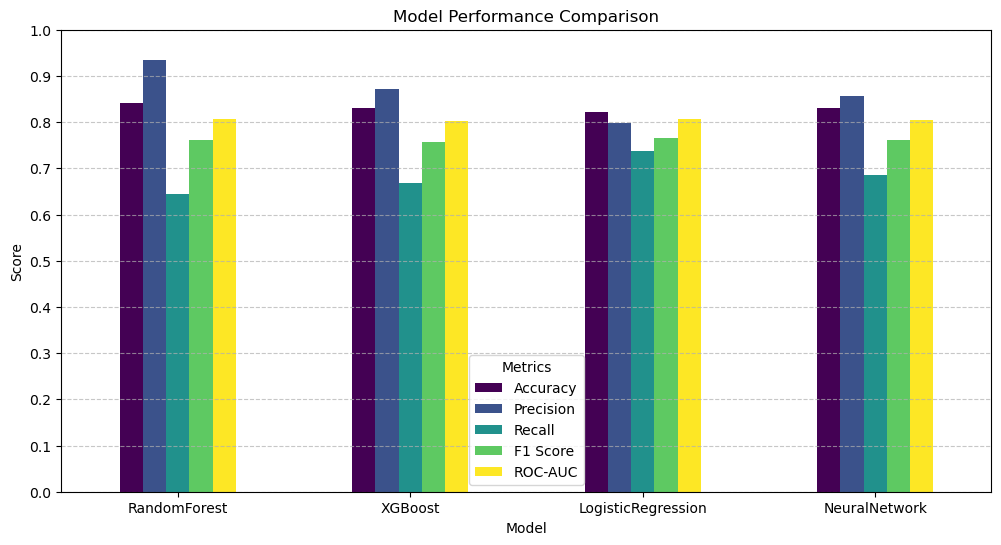

In [53]:
# Replace these variables with actual predictions from your models
models = ["RandomForest", "XGBoost", "LogisticRegression", "NeuralNetwork"]

accuracy = [
    accuracy_score(y_test, y_pred_rnd),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_logit),
    accuracy_score(y_test, y_pred_nn)
]

precision = [
    precision_score(y_test, y_pred_rnd),
    precision_score(y_test, y_pred_xgb),
    precision_score(y_test, y_pred_logit),
    precision_score(y_test, y_pred_nn)
]

recall = [
    recall_score(y_test, y_pred_rnd),
    recall_score(y_test, y_pred_xgb),
    recall_score(y_test, y_pred_logit),
    recall_score(y_test, y_pred_nn)
]

f1_score_values = [
    f1_score(y_test, y_pred_rnd),
    f1_score(y_test, y_pred_xgb),
    f1_score(y_test, y_pred_logit),
    f1_score(y_test, y_pred_nn)
]

roc_auc_scores = [
    roc_auc_score(y_test, y_pred_rnd),
    roc_auc_score(y_test, y_pred_xgb),
    roc_auc_score(y_test, y_pred_logit),
    roc_auc_score(y_test, y_pred_nn)
]

# Convert metrics to DataFrame
df_metrics = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score_values,
    "ROC-AUC": roc_auc_scores
})

# 📊 Plot Performance Metrics
fig, ax = plt.subplots(figsize=(12, 6))
df_metrics.set_index("Model").plot(kind="bar", ax=ax, rot=0, colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend

# Adjust Y-axis limits slightly above the highest score
plt.ylim(0, 1)

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set y-axis ticks with a step of 0.1
plt.yticks([i/10 for i in range(0, 11)])  # Generates ticks at 0.0, 0.1, ..., 1.0

plt.legend(title="Metrics")

# Show the plot
plt.show()


In [54]:
import pandas as pd
from IPython.display import display

# Convert metrics to DataFrame
df_metrics = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score_values,
    "ROC-AUC": roc_auc_scores
})

# Display sorted tables for each metric with only that metric's column
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]

for metric in metrics:
    print(f"📊 Models sorted by {metric} (Best to Worst):")
    df_sorted = df_metrics[["Model", metric]].sort_values(by=metric, ascending=False).reset_index(drop=True)
    display(df_sorted)


📊 Models sorted by Accuracy (Best to Worst):


,Model,Accuracy
0,RandomForest,0.840693
1,XGBoost,0.829781
2,NeuralNetwork,0.829490
3,LogisticRegression,0.821416


📊 Models sorted by Precision (Best to Worst):


,Model,Precision
0,RandomForest,0.933706
1,XGBoost,0.872662
2,NeuralNetwork,0.855963
3,LogisticRegression,0.797456


📊 Models sorted by Recall (Best to Worst):


,Model,Recall
0,LogisticRegression,0.736417
1,NeuralNetwork,0.685022
2,XGBoost,0.667952
3,RandomForest,0.643722


📊 Models sorted by F1 Score (Best to Worst):


,Model,F1 Score
0,LogisticRegression,0.765722
1,RandomForest,0.762060
2,NeuralNetwork,0.761011
3,XGBoost,0.756706


📊 Models sorted by ROC-AUC (Best to Worst):


,Model,ROC-AUC
0,RandomForest,0.806859
1,LogisticRegression,0.806816
2,NeuralNetwork,0.804675
3,XGBoost,0.801984
